In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-obj/5.obj
/kaggle/input/dataset-obj/34.obj
/kaggle/input/dataset-obj/20.obj
/kaggle/input/dataset-obj/19.obj
/kaggle/input/dataset-obj/24.obj
/kaggle/input/dataset-obj/38.obj
/kaggle/input/dataset-obj/43.obj
/kaggle/input/dataset-obj/10.obj
/kaggle/input/dataset-obj/23.obj
/kaggle/input/dataset-obj/41.obj
/kaggle/input/dataset-obj/39.obj
/kaggle/input/dataset-obj/22.obj
/kaggle/input/dataset-obj/28.obj
/kaggle/input/dataset-obj/30.obj
/kaggle/input/dataset-obj/33.obj
/kaggle/input/dataset-obj/17.obj
/kaggle/input/dataset-obj/45.obj
/kaggle/input/dataset-obj/40.obj
/kaggle/input/dataset-obj/2.obj
/kaggle/input/dataset-obj/12.obj
/kaggle/input/dataset-obj/35.obj
/kaggle/input/dataset-obj/25.obj
/kaggle/input/dataset-obj/47.obj
/kaggle/input/dataset-obj/44.obj
/kaggle/input/dataset-obj/49.obj
/kaggle/input/dataset-obj/36.obj
/kaggle/input/dataset-obj/3.obj
/kaggle/input/dataset-obj/13.obj
/kaggle/input/dataset-obj/8.obj
/kaggle/input/dataset-obj/37.obj
/kaggle/input/

In [62]:
!pip install trimesh==3.22.0

In [63]:
!pip install rtree

In [64]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import torch
from torch import nn
import torch.nn.functional as F
from typing import List
import math
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import trimesh
import torch.optim.lr_scheduler as lr_scheduler
import re
import rtree
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import os


In [65]:
class PointCloud(Dataset):
    def __init__(self, path, on_surface_points, off_surface_points, keep_aspect_ratio=True):
        super(PointCloud, self).__init__()

        mesh = trimesh.load_mesh(path)
        vertices = mesh.vertices
        vertex_normals = mesh.vertex_normals

        self.coords = self.process_coordinates(vertices)
        self.normals = vertex_normals
        self.on_surface_points = on_surface_points
        self.off_surface_points = off_surface_points

    def process_coordinates(self, vertices):
        centered_coords = vertices - np.mean(vertices, axis=0, keepdims=True)
        normalized_coords = self.normalize_coordinates(centered_coords)
        return normalized_coords

    def normalize_coordinates(self, coords):
        coord_max = np.amax(coords)
        coord_min = np.amin(coords)
        normalized_coords = (coords - coord_min) / (coord_max - coord_min)
        normalized_coords -= 0.5
        normalized_coords *= 2.
        return normalized_coords

    def __len__(self):
        return self.coords.shape[0] // self.on_surface_points

    def __getitem__(self, idx):
        on_surface_coords, on_surface_normals = self.sample_on_surface_points()
        off_surface_coords, off_surface_normals = self.sample_off_surface_points()

        sdf, coords, normals = self.create_sdf_and_concatenate(on_surface_coords, off_surface_coords, on_surface_normals, off_surface_normals)

        return {'coords': torch.from_numpy(coords).float()}, {'sdf': torch.from_numpy(sdf).float(),
                                                              'normals': torch.from_numpy(normals).float()}

    def sample_on_surface_points(self):
        point_cloud_size = self.coords.shape[0]
        rand_idcs = np.random.choice(point_cloud_size, size=self.on_surface_points)
        on_surface_coords = self.coords[rand_idcs, :]
        on_surface_normals = self.normals[rand_idcs, :]
        return on_surface_coords, on_surface_normals

    def sample_off_surface_points(self):
        off_surface_coords = np.random.uniform(-1, 1, size=(self.off_surface_points, 3))
        off_surface_normals = np.ones((self.off_surface_points, 3)) * -1
        return off_surface_coords, off_surface_normals

    def create_sdf_and_concatenate(self, on_surface_coords, off_surface_coords, on_surface_normals, off_surface_normals):
        total_samples = self.on_surface_points + self.off_surface_points
        sdf = np.zeros((total_samples, 1))
        sdf[self.on_surface_points:, :] = -1 
        coords = np.concatenate((on_surface_coords, off_surface_coords), axis=0)
        normals = np.concatenate((on_surface_normals, off_surface_normals), axis=0)
        return sdf, coords, normals


In [66]:
import torch
import torch.nn as nn
import numpy as np

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super(SineLayer, self).__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.initialize_weights()
    
    def initialize_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                scale = np.sqrt(6 / self.in_features) / self.omega_0
                self.linear.weight.uniform_(-scale, scale)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, 
                 first_omega_0=30, hidden_omega_0=30.):
        super(Siren, self).__init__()
        
        self.layers = []
        self.layers.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for _ in range(hidden_layers):
            self.layers.append(SineLayer(hidden_features, hidden_features, is_first=False, omega_0=hidden_omega_0))

        self.layers.append(SineLayer(hidden_features, out_features, is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.layers)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return {'model_in': coords, 'model_out': output}


In [67]:
def compute_sdf_gradients(pred_sdf, coords):
    grad_outputs = torch.ones_like(pred_sdf)
    return torch.autograd.grad(pred_sdf, [coords], grad_outputs=grad_outputs, create_graph=True)[0]

def apply_sdf_constraints(gt_sdf, pred_sdf, gradients, gt_normals):
    sdf_constraint = torch.where(gt_sdf != -1, pred_sdf, torch.zeros_like(pred_sdf))
    inter_constraint = torch.where(gt_sdf != -1, torch.zeros_like(pred_sdf), torch.exp(-1e2 * torch.abs(pred_sdf)))
    normal_constraint = torch.where(gt_sdf != -1, 1 - F.cosine_similarity(gradients, gt_normals, dim=-1)[..., None],
                                    torch.zeros_like(gradients[..., :1]))
    grad_constraint = torch.abs(gradients.norm(dim=-1) - 1)

    return sdf_constraint, inter_constraint, normal_constraint, grad_constraint

def compute_loss_contributions(sdf_constraint, inter_constraint, normal_constraint, grad_constraint):
    losses = {
        'sdf': torch.abs(sdf_constraint).mean() * 3e3,
        'inter': inter_constraint.mean() * 1e2,
        'normal_constraint': normal_constraint.mean() * 1e2,
        'grad_constraint': grad_constraint.mean() * 5e1
    }
    return losses

def compute_total_loss(loss_contributions):
    total_loss = sum(loss.mean() for loss in loss_contributions.values())
    return total_loss

def sdf_loss(model_output, gt):
    gt_sdf = gt['sdf']
    gt_normals = gt['normals']

    coords = model_output['model_in']
    pred_sdf = model_output['model_out']

    gradients = compute_sdf_gradients(pred_sdf, coords)

    sdf_constraint, inter_constraint, normal_constraint, grad_constraint = apply_sdf_constraints(gt_sdf, pred_sdf, gradients, gt_normals)

    loss_contributions = compute_loss_contributions(sdf_constraint, inter_constraint, normal_constraint, grad_constraint)

    total_loss = compute_total_loss(loss_contributions)

    return total_loss

In [68]:
in_features = 3  
hidden_features = 512  
hidden_layers = 5
out_features = 1 
batch_size = 64
lr = 1e-4
num_epochs = 100
model = Siren(in_features, hidden_features, hidden_layers, out_features)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True, mode = "min")


In [69]:
def train_single_epoch(model, optimizer, scheduler, sdf_dataset, dataloader, device):
    total_loss = 0.0
    model.train()

    for batch in dataloader:
        coords = batch[0]['coords'].to(device)
        targets = {key: value.to(device) for key, value in batch[1].items()}

        optimizer.zero_grad()
        output = model(coords)

        loss = sdf_loss(output, targets)

        loss.backward()

        optimizer.step()
        scheduler.step(loss)
        total_loss += loss.item() * coords.size(0)

    average_loss = total_loss / len(sdf_dataset)
    return average_loss

def plot_training_losses(train_losses):
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

def train_model_pipeline(model, optimizer, scheduler, sdf_dataset, dataloader, device, num_epochs):
    train_losses = []

    for epoch in range(num_epochs):
        average_loss = train_single_epoch(model, optimizer, scheduler, sdf_dataset, dataloader, device)
        train_losses.append(average_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}")

    plot_training_losses(train_losses)

    return model

In [70]:
def generate_sample_points(mesh, num_points):
    points, _ = trimesh.sample.sample_surface(mesh, num_points)
    points = points + np.random.normal(loc=0, scale=1e-2, size=points.shape)
    return points

def generate_random_points_inside_volume(mesh, num_points):
    bounds = mesh.bounds
    points = np.random.uniform(bounds[0], bounds[1], size=(num_points, 3))
    points = points + np.random.normal(loc=0, scale=1e-2, size=points.shape)
    return points

def compute_signed_distance(mesh, points):
    return trimesh.proximity.signed_distance(mesh, points)

def evaluate_sdf_model(model, device, points_tensor):
    with torch.no_grad():
        model.eval()
        points_tensor = torch.from_numpy(points_tensor).float().to(device)
        sdf_values = model(points_tensor)['model_out']
        return sdf_values.cpu().numpy()

def compute_ground_truth_labels(mesh, points):
    return (compute_signed_distance(mesh, points) > 0).astype(int)

def binarize_sdf_values(sdf_values):
    return (sdf_values > 0).astype(int)

def evaluate_f1_score(gt_labels, predicted_labels):
    return f1_score(gt_labels, predicted_labels, average='weighted')


def eval_model(obj_name, model, device, index):
    mesh = trimesh.load_mesh(obj_name)

    points_on_surface = generate_sample_points(mesh, 1000)
    points_inside_volume = generate_random_points_inside_volume(mesh, 1000)

    sdf_surface = compute_signed_distance(mesh, points_on_surface)
    sdf_inside = compute_signed_distance(mesh, points_inside_volume)

    start_time = time.time()
    sdf_values_surface = evaluate_sdf_model(model, device, points_on_surface)
    sdf_values_inside = evaluate_sdf_model(model, device, points_inside_volume)
    elapsed_time = time.time() - start_time
    
    gt_labels_surface = compute_ground_truth_labels(mesh, points_on_surface)
    gt_labels_inside = compute_ground_truth_labels(mesh, points_inside_volume)

    sdf_values_surface_bin = binarize_sdf_values(sdf_values_surface)
    sdf_values_inside_bin = binarize_sdf_values(sdf_values_inside)

    surface_f1 = evaluate_f1_score(gt_labels_surface, sdf_values_surface_bin)
    print("Surface F1 Score:", surface_f1)

    inside_f1 = evaluate_f1_score(gt_labels_inside, sdf_values_inside_bin)
    print("Inside F1 Score:", inside_f1)

    torch.save(model.state_dict(), f'model_{index}.pth')

    return surface_f1, inside_f1, elapsed_time


In [71]:
surf_f1_lst = []
in_f1_lst = []
batch_ret = []

In [77]:
print(np.mean(surf_f1_lst))
print(np.mean(in_f1_lst))
print(np.mean(batch_ret))

0.4076579586533953
0.4625561133672501
0.004657868681282833


In [79]:
print("average time", np.mean(batch_ret) * 1000)

average time 4.657868681282833


/kaggle/input/dataset-obj/5.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 804.9953526088169
Epoch 2/100, Loss: 424.58335658482144
Epoch 00043: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00062: reducing learning rate of group 0 to 1.0000e-07.
Epoch 3/100, Loss: 316.80057925269716
Epoch 00081: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 276.6657925560361
Epoch 5/100, Loss: 279.2632998511905
Epoch 6/100, Loss: 272.86566234770277
Epoch 7/100, Loss: 273.91722906203495
Epoch 8/100, Loss: 269.49288504464283
Epoch 9/100, Loss: 268.16309320359005
Epoch 10/100, Loss: 268.33804902576264
Epoch 11/100, Loss: 271.06070309593565
Epoch 12/100, Loss: 267.3268585205078
Epoch 13/100, Loss: 269.2545427594866
Epoch 14/100, Loss: 266.53898257300966
Epoch 15/100, Loss: 270.1470155261812
Epoch 16/100, Loss: 265.05867367699034
Epoch 17/100, Loss: 266.89242771693637
Epoch 18/100, Loss: 266.35810924711683
Epoch 19/100, Loss: 270.790041242

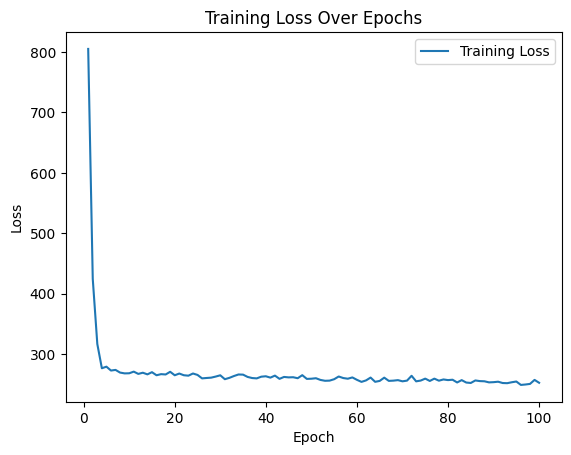

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:525: RuntimeWarning: invalid value encountered in subtract
  barycentric[:, 0] = 1 - barycentric[:, 1] - barycentric[:, 2]


Surface F1 Score: 0.4601821167338408
Inside F1 Score: 0.39717061733605313
/kaggle/input/dataset-obj/34.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 985.5469970703125
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch 2/100, Loss: 844.9185791015625
Epoch 3/100, Loss: 674.1966891818577
Epoch 4/100, Loss: 566.7941623263889
Epoch 5/100, Loss: 515.551510281033
Epoch 6/100, Loss: 478.9415011935764
Epoch 7/100, Loss: 447.66362847222223
Epoch 8/100, Loss: 410.9745619032118
Epoch 9/100, Loss: 393.1257832845052
Epoch 10/100, Loss: 377.1478576660156
Epoch 11/100, Loss: 358.6698404947917
Epoch 12/100, Loss: 347.92471991644965
Epoch 00109: reducing learning rate of group 0 to 1.0000e-07.
Epoch 13/100, Loss: 342.3147277832031
Epoch 14/100, Loss: 333.01659817165796
Epoch 00132: reducing learning rate of group 0 to 1.0000e-08.
Epoch 15/100, Loss: 336.6710035536024
Epoch 16/100, Loss: 332.88228013780383
Epoch 17/100, Loss: 327.8882988823785
Epoch

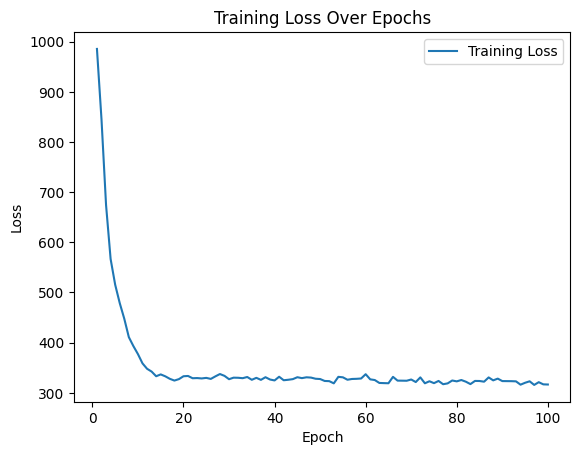

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.401884744451963
Inside F1 Score: 0.9135233050847458
/kaggle/input/dataset-obj/20.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 634.4301891326904
Epoch 00053: reducing learning rate of group 0 to 1.0000e-06.
Epoch 2/100, Loss: 278.3139057159424
Epoch 00080: reducing learning rate of group 0 to 1.0000e-07.
Epoch 3/100, Loss: 184.23604249954224
Epoch 00105: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 172.384174823761
Epoch 5/100, Loss: 169.00611925125122
Epoch 6/100, Loss: 166.86576557159424
Epoch 7/100, Loss: 168.81876182556152
Epoch 8/100, Loss: 167.8799319267273
Epoch 9/100, Loss: 167.02418088912964
Epoch 10/100, Loss: 169.14607334136963
Epoch 11/100, Loss: 167.73564767837524
Epoch 12/100, Loss: 166.5510139465332
Epoch 13/100, Loss: 166.8962631225586
Epoch 14/100, Loss: 166.459086894989
Epoch 15/100, Loss: 164.08999013900757
Epoch 16/100, Loss: 163.7301926612854
Epoch 17/100, Loss: 166.71496152877808
Epo

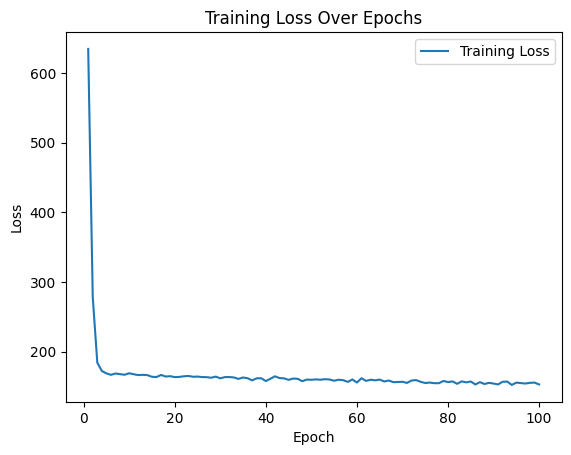

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.5004855954747808
Inside F1 Score: 0.6166444825055054
/kaggle/input/dataset-obj/19.obj
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 910.9967416616587
Epoch 2/100, Loss: 457.5818117581881
Epoch 3/100, Loss: 336.27776395357574
Epoch 00088: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00094: reducing learning rate of group 0 to 1.0000e-07.
Epoch 4/100, Loss: 279.7141441932091
Epoch 00116: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 243.49117924616888
Epoch 6/100, Loss: 244.2792998093825
Epoch 7/100, Loss: 244.06609344482422
Epoch 8/100, Loss: 240.6611580481896
Epoch 9/100, Loss: 242.97591048020584
Epoch 10/100, Loss: 241.81259448711688
Epoch 11/100, Loss: 238.76549177903397
Epoch 12/100, Loss: 241.74237764798679
Epoch 13/100, Loss: 238.94127655029297
Epoch 14/100, Loss: 240.77726452167218
Epoch 15/100, Loss: 235.4672880906325
Epoch 16/100, Loss: 237.3617201585036
Epoch 17/100, Loss: 233.98940042349008

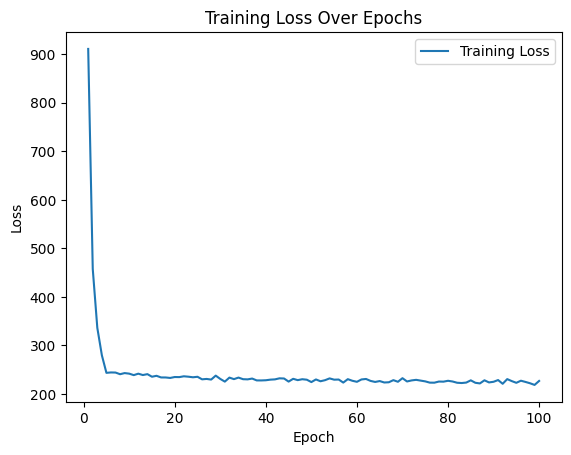

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.369520744908367
Inside F1 Score: 0.07799033883099855
/kaggle/input/dataset-obj/24.obj
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 937.6101046475497
Epoch 2/100, Loss: 489.150371204723
Epoch 00064: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 347.02533929998225
Epoch 4/100, Loss: 258.3348187533292
Epoch 00102: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00108: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 220.71471959894353
Epoch 6/100, Loss: 216.87071990966797
Epoch 7/100, Loss: 216.63062979958275
Epoch 8/100, Loss: 213.58097145774147
Epoch 9/100, Loss: 214.32966683127663
Epoch 10/100, Loss: 217.27788613059303
Epoch 11/100, Loss: 215.53224112770775
Epoch 12/100, Loss: 209.18314639004794
Epoch 13/100, Loss: 215.03413183038884
Epoch 14/100, Loss: 212.02970400723544
Epoch 15/100, Loss: 212.1247163252397
Epoch 16/100, Loss: 210.90644350918856
Epoch 17/100, Loss: 214.980501348322

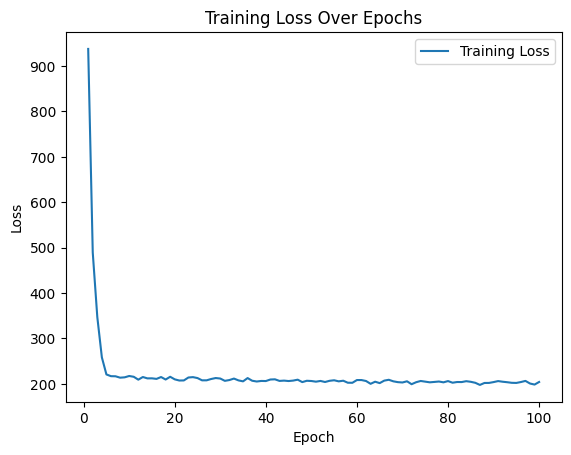

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.3729250811964719
Inside F1 Score: 0.379114650811962
/kaggle/input/dataset-obj/38.obj
Epoch 1/100, Loss: 934.602880859375
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 2/100, Loss: 926.7209350585938
Epoch 3/100, Loss: 708.614501953125
Epoch 4/100, Loss: 592.3109741210938
Epoch 5/100, Loss: 515.2649047851562
Epoch 6/100, Loss: 461.87962036132814
Epoch 7/100, Loss: 423.6758605957031
Epoch 8/100, Loss: 407.9234191894531
Epoch 9/100, Loss: 391.493701171875
Epoch 10/100, Loss: 377.6896606445313
Epoch 11/100, Loss: 365.5278076171875
Epoch 12/100, Loss: 348.912060546875
Epoch 13/100, Loss: 318.5657470703125
Epoch 00066: reducing learning rate of group 0 to 1.0000e-06.
Epoch 14/100, Loss: 298.3024536132813
Epoch 15/100, Loss: 280.5842712402344
Epoch 16/100, Loss: 276.30726318359376
Epoch 17/100, Loss: 267.3454864501953
Epoch 18/100, Loss: 251.99779357910157
Epoch 19/100, Loss: 246.52232666015624
Epoch 20/100, Loss: 246.6666046142578
Epoch 00101: reducin

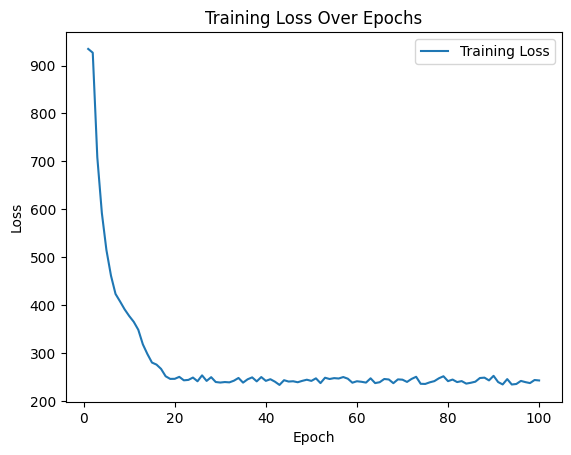

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.4717042150680385
Inside F1 Score: 0.21004992556967825
/kaggle/input/dataset-obj/43.obj
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 849.3963787372296
Epoch 2/100, Loss: 352.0245361328125
Epoch 00069: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 251.08473088191107
Epoch 00089: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00103: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 194.015383206881
Epoch 5/100, Loss: 183.12241774338943
Epoch 6/100, Loss: 177.73822314922626
Epoch 7/100, Loss: 180.03861353947565
Epoch 8/100, Loss: 175.1739243727464
Epoch 9/100, Loss: 178.00697913536658
Epoch 10/100, Loss: 181.8699939434345
Epoch 11/100, Loss: 181.81243603046124
Epoch 12/100, Loss: 179.78060208834134
Epoch 13/100, Loss: 174.17535106952374
Epoch 14/100, Loss: 175.13026076096756
Epoch 15/100, Loss: 173.4909186730018
Epoch 16/100, Loss: 178.48030442457932
Epoch 17/100, Loss: 181.4775631244365

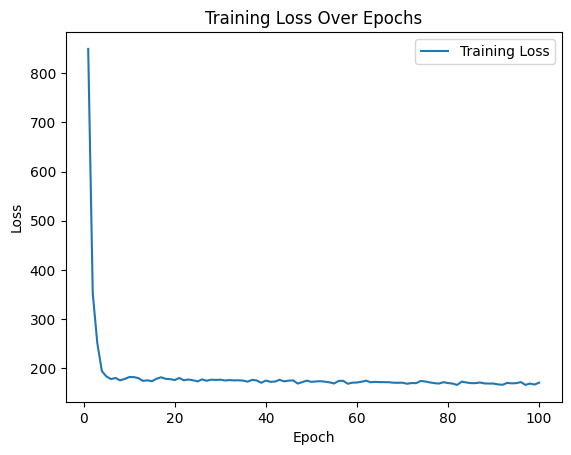

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.518252460509264
Inside F1 Score: 0.6799802097763705
/kaggle/input/dataset-obj/10.obj
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 801.9645566587095
Epoch 00046: reducing learning rate of group 0 to 1.0000e-06.
Epoch 2/100, Loss: 417.2431957103588
Epoch 00070: reducing learning rate of group 0 to 1.0000e-07.
Epoch 3/100, Loss: 280.29167118778935
Epoch 00087: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 260.3793753164786
Epoch 5/100, Loss: 260.6442266393591
Epoch 6/100, Loss: 257.6533610026042
Epoch 7/100, Loss: 256.21774235478154
Epoch 8/100, Loss: 257.2792680528429
Epoch 9/100, Loss: 256.8338187888817
Epoch 10/100, Loss: 258.8076827437789
Epoch 11/100, Loss: 256.9427134195964
Epoch 12/100, Loss: 256.0977981002242
Epoch 13/100, Loss: 256.677173755787
Epoch 14/100, Loss: 260.50313991970484
Epoch 15/100, Loss: 252.93798432526765
Epoch 16/100, Loss: 253.28020788122106
Epoch 17/100, Loss: 256.15533560293693
Epoch

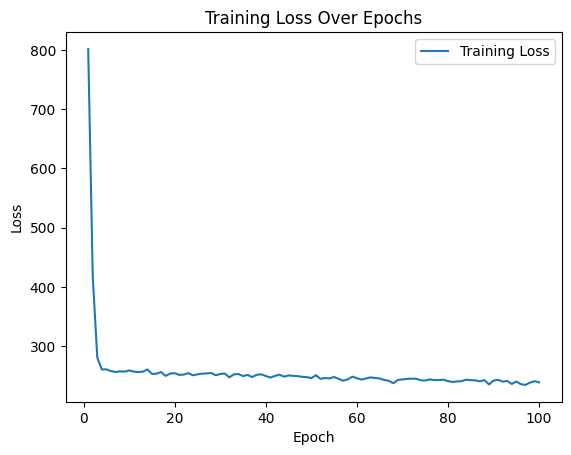

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.5694531375496837
Inside F1 Score: 0.8831444911965359
/kaggle/input/dataset-obj/23.obj
Epoch 1/100, Loss: 1062.8557535807292
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 2/100, Loss: 1186.293965657552
Epoch 00015: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 981.821055094401
Epoch 4/100, Loss: 840.3617655436198
Epoch 5/100, Loss: 702.150889078776
Epoch 6/100, Loss: 639.1707763671875
Epoch 7/100, Loss: 587.4019368489584
Epoch 8/100, Loss: 539.2816162109375
Epoch 9/100, Loss: 506.07061258951825
Epoch 10/100, Loss: 484.887446085612
Epoch 11/100, Loss: 470.6180419921875
Epoch 12/100, Loss: 445.33204650878906
Epoch 13/100, Loss: 449.1281382242839
Epoch 00081: reducing learning rate of group 0 to 1.0000e-07.
Epoch 14/100, Loss: 441.6822560628255
Epoch 15/100, Loss: 411.9091339111328
Epoch 00095: reducing learning rate of group 0 to 1.0000e-08.
Epoch 16/100, Loss: 427.789794921875
Epoch 17/100, Loss: 427.32334391276044
Epoch 18/

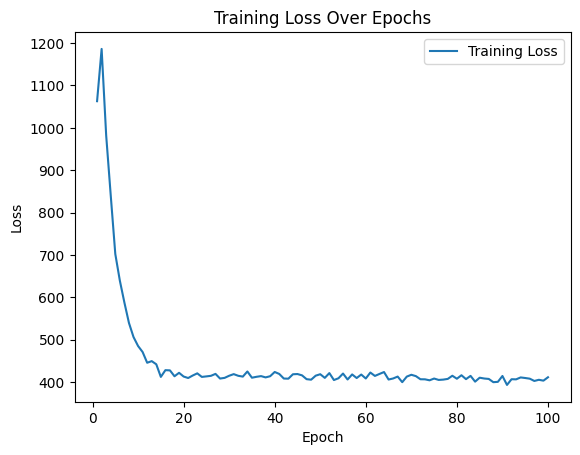

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.4356114843011395
Inside F1 Score: 0.176387181593095
/kaggle/input/dataset-obj/41.obj
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 904.1719665527344
Epoch 2/100, Loss: 767.2688064575195
Epoch 3/100, Loss: 542.1686973571777
Epoch 4/100, Loss: 409.74646759033203
Epoch 5/100, Loss: 344.67204666137695
Epoch 00045: reducing learning rate of group 0 to 1.0000e-06.
Epoch 6/100, Loss: 331.35982513427734
Epoch 7/100, Loss: 294.2714080810547
Epoch 8/100, Loss: 259.54361152648926
Epoch 00072: reducing learning rate of group 0 to 1.0000e-07.
Epoch 9/100, Loss: 246.04639625549316
Epoch 00080: reducing learning rate of group 0 to 1.0000e-08.
Epoch 10/100, Loss: 228.31019592285156
Epoch 11/100, Loss: 231.80786323547363
Epoch 12/100, Loss: 231.22695350646973
Epoch 13/100, Loss: 234.31767463684082
Epoch 14/100, Loss: 231.71079063415527
Epoch 15/100, Loss: 230.10071754455566
Epoch 16/100, Loss: 231.8793544769287
Epoch 17/100, Loss: 228.9670600891113

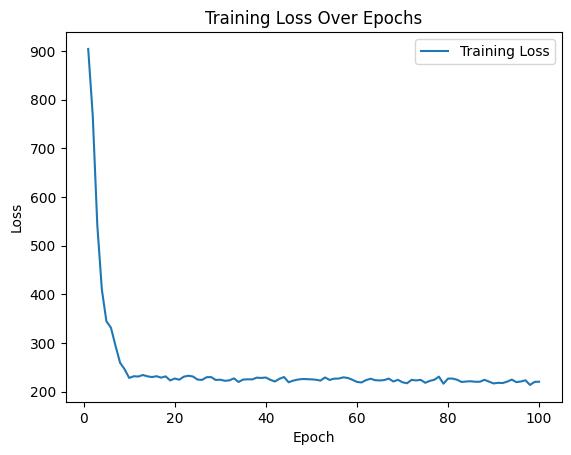

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.41254546885658805
Inside F1 Score: 0.12896478695688715
/kaggle/input/dataset-obj/39.obj
Epoch 1/100, Loss: 1084.5469156901042
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Epoch 2/100, Loss: 997.9524332682291
Epoch 3/100, Loss: 626.7146606445312
Epoch 4/100, Loss: 457.11392550998266
Epoch 5/100, Loss: 366.5704040527344
Epoch 6/100, Loss: 310.21397569444446
Epoch 7/100, Loss: 297.4202236599392
Epoch 00064: reducing learning rate of group 0 to 1.0000e-06.
Epoch 8/100, Loss: 275.46834648980035
Epoch 9/100, Loss: 229.44315592447916
Epoch 10/100, Loss: 207.37437099880643
Epoch 00096: reducing learning rate of group 0 to 1.0000e-07.
Epoch 11/100, Loss: 196.97949049207898
Epoch 12/100, Loss: 190.8416510687934
Epoch 00112: reducing learning rate of group 0 to 1.0000e-08.
Epoch 13/100, Loss: 185.60803900824652
Epoch 14/100, Loss: 190.71839057074652
Epoch 15/100, Loss: 186.08863830566406
Epoch 16/100, Loss: 184.79096476236978
Epoch 17/100, Loss: 185.4305708143

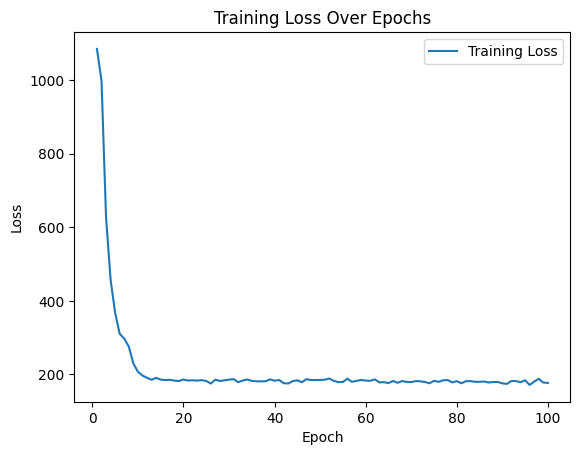

Surface F1 Score: 0.28898041733547347
Inside F1 Score: 0.04980499921999688
/kaggle/input/dataset-obj/22.obj
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 1033.8397921048677
Epoch 00014: reducing learning rate of group 0 to 1.0000e-06.
Epoch 2/100, Loss: 748.8517596905048
Epoch 3/100, Loss: 598.8208571213943
Epoch 4/100, Loss: 521.5827261117788
Epoch 5/100, Loss: 454.84471247746393
Epoch 00066: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6/100, Loss: 429.98209791917066
Epoch 00082: reducing learning rate of group 0 to 1.0000e-08.
Epoch 7/100, Loss: 423.57386192908655
Epoch 8/100, Loss: 428.34614915114184
Epoch 9/100, Loss: 420.55157705453723
Epoch 10/100, Loss: 432.36162625826324
Epoch 11/100, Loss: 421.6786452073317
Epoch 12/100, Loss: 421.98460505558893
Epoch 13/100, Loss: 420.90623591496393
Epoch 14/100, Loss: 421.7152569110577
Epoch 15/100, Loss: 418.0919447678786
Epoch 16/100, Loss: 413.4109379695012
Epoch 17/100, Loss: 414.728891225961

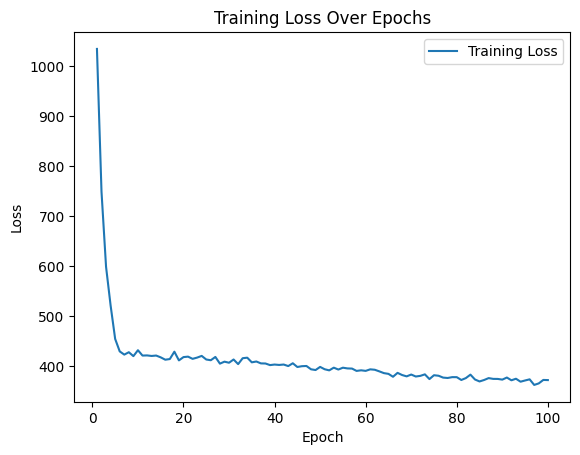

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.4177072145054705
Inside F1 Score: 0.15079429987608425
/kaggle/input/dataset-obj/28.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 792.1702945106908
Epoch 2/100, Loss: 369.24764211554276
Epoch 00042: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 257.6086385626542
Epoch 4/100, Loss: 195.55074752004523
Epoch 00078: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00086: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 180.47562448601974
Epoch 6/100, Loss: 177.75706883480674
Epoch 7/100, Loss: 177.4369290000514
Epoch 8/100, Loss: 177.08331459446958
Epoch 9/100, Loss: 180.3743029142681
Epoch 10/100, Loss: 177.92547527112458
Epoch 11/100, Loss: 178.62520237972862
Epoch 12/100, Loss: 178.60656818590667
Epoch 13/100, Loss: 176.88671553762336
Epoch 14/100, Loss: 176.38361559416117
Epoch 15/100, Loss: 178.3010213751542
Epoch 16/100, Loss: 179.43353753340872
Epoch 17/100, Loss: 172.61285721628

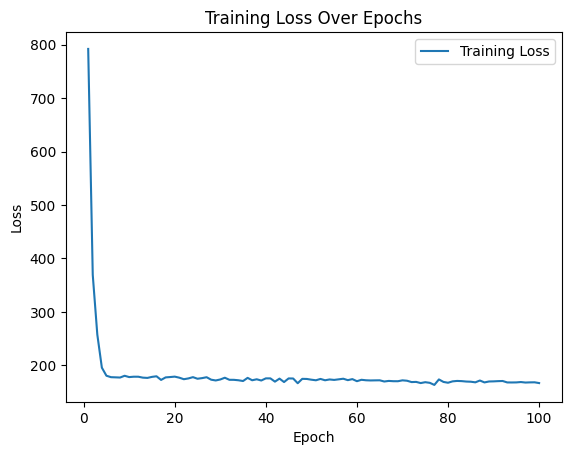

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.2900126619272152
Inside F1 Score: 0.10908835124568551
/kaggle/input/dataset-obj/30.obj
Epoch 1/100, Loss: 983.5096130371094
Epoch 2/100, Loss: 1120.2784423828125
Epoch 3/100, Loss: 1135.784912109375
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 4/100, Loss: 1132.5611572265625
Epoch 5/100, Loss: 1019.9000549316406
Epoch 6/100, Loss: 908.1613159179688
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch 7/100, Loss: 861.5521850585938
Epoch 8/100, Loss: 792.3717651367188
Epoch 9/100, Loss: 725.7463073730469
Epoch 10/100, Loss: 630.2895812988281
Epoch 11/100, Loss: 580.3344116210938
Epoch 12/100, Loss: 552.1654663085938
Epoch 13/100, Loss: 549.0016784667969
Epoch 14/100, Loss: 538.8154907226562
Epoch 15/100, Loss: 484.93743896484375
Epoch 16/100, Loss: 456.4630584716797
Epoch 17/100, Loss: 462.32098388671875
Epoch 18/100, Loss: 454.5110778808594
Epoch 19/100, Loss: 428.4154052734375
Epoch 20/100, Loss: 421.0133819580078
Epoch 21/100,

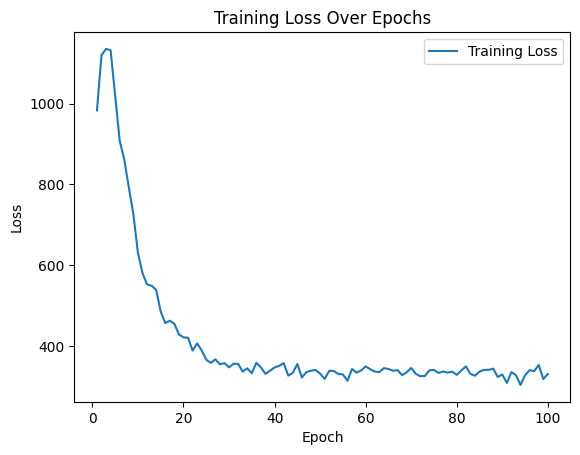

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.28880191912268677
Inside F1 Score: 0.09713643659711076
/kaggle/input/dataset-obj/33.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 776.9231860351563
Epoch 2/100, Loss: 415.50646728515625
Epoch 00072: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 307.4798742675781
Epoch 00096: reducing learning rate of group 0 to 1.0000e-07.
Epoch 4/100, Loss: 231.11067016601564
Epoch 00103: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 213.48466674804686
Epoch 6/100, Loss: 205.8684326171875
Epoch 7/100, Loss: 204.2517224121094
Epoch 8/100, Loss: 206.1113946533203
Epoch 9/100, Loss: 206.28824462890626
Epoch 10/100, Loss: 203.89355834960938
Epoch 11/100, Loss: 203.14281127929686
Epoch 12/100, Loss: 201.8325439453125
Epoch 13/100, Loss: 203.4059899902344
Epoch 14/100, Loss: 203.448779296875
Epoch 15/100, Loss: 204.00444702148437
Epoch 16/100, Loss: 205.23231506347656
Epoch 17/100, Loss: 202.67987854003906

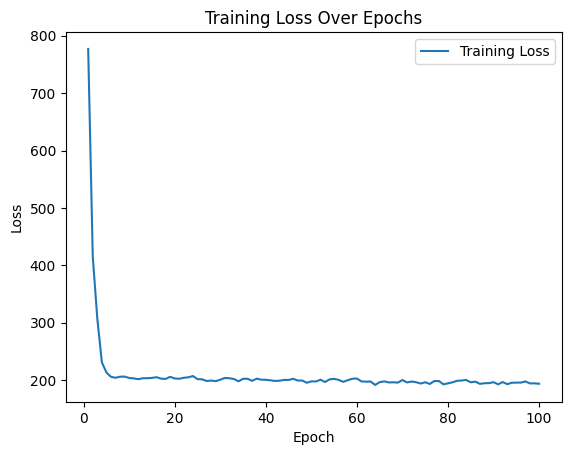

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.27432847222222223
Inside F1 Score: 0.08340228625230361
/kaggle/input/dataset-obj/17.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 660.2231913975307
Epoch 2/100, Loss: 318.60801533290316
Epoch 00061: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 224.53806849888392
Epoch 00110: reducing learning rate of group 0 to 1.0000e-07.
Epoch 4/100, Loss: 185.74313953944616
Epoch 00116: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 178.23540496826172
Epoch 6/100, Loss: 175.8710103716169
Epoch 7/100, Loss: 178.74682290213448
Epoch 8/100, Loss: 179.1526036943708
Epoch 9/100, Loss: 179.17212677001953
Epoch 10/100, Loss: 181.37619291033064
Epoch 11/100, Loss: 175.02696119035994
Epoch 12/100, Loss: 179.39424405779158
Epoch 13/100, Loss: 175.2917104448591
Epoch 14/100, Loss: 174.5997761317662
Epoch 15/100, Loss: 178.88584463936942
Epoch 16/100, Loss: 181.62621198381697
Epoch 17/100, Loss: 174.3854686192

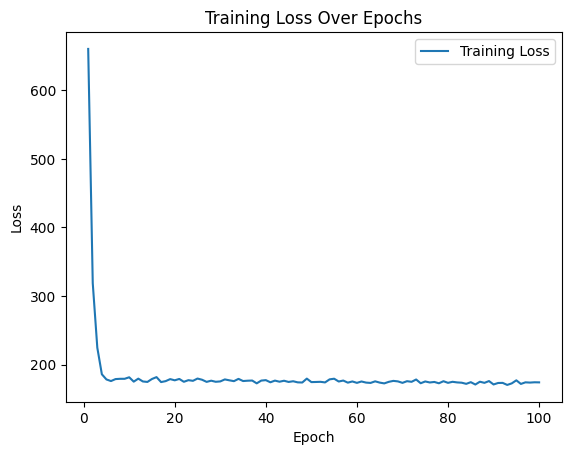

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.4464598342564444
Inside F1 Score: 0.8380827147401909
/kaggle/input/dataset-obj/45.obj
Epoch 1/100, Loss: 1000.3589782714844
Epoch 2/100, Loss: 996.2444915771484
Epoch 00012: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3/100, Loss: 1055.4220275878906
Epoch 4/100, Loss: 1002.2664642333984
Epoch 00018: reducing learning rate of group 0 to 1.0000e-06.
Epoch 5/100, Loss: 838.6724700927734
Epoch 6/100, Loss: 771.3905944824219
Epoch 7/100, Loss: 705.2586364746094
Epoch 8/100, Loss: 654.0292053222656
Epoch 9/100, Loss: 598.1612243652344
Epoch 10/100, Loss: 571.3458099365234
Epoch 11/100, Loss: 522.048095703125
Epoch 12/100, Loss: 487.86022186279297
Epoch 13/100, Loss: 450.57814025878906
Epoch 14/100, Loss: 453.9809265136719
Epoch 00057: reducing learning rate of group 0 to 1.0000e-07.
Epoch 15/100, Loss: 438.28907012939453
Epoch 00064: reducing learning rate of group 0 to 1.0000e-08.
Epoch 16/100, Loss: 435.43556213378906
Epoch 17/100, Loss: 432.1741180419922
Epo

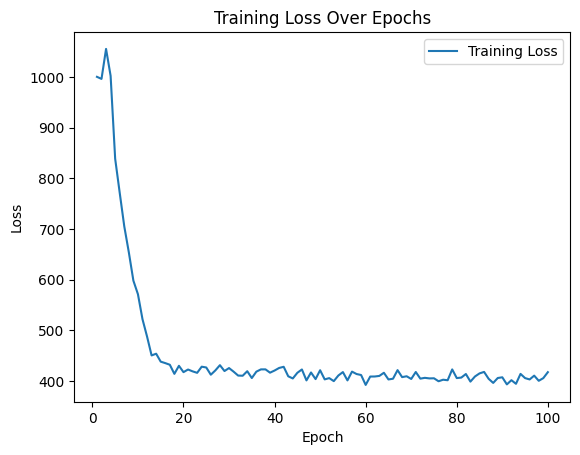

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.3008246213971666
Inside F1 Score: 0.2599891222108459
/kaggle/input/dataset-obj/40.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 950.452294921875
Epoch 2/100, Loss: 664.7345581054688
Epoch 3/100, Loss: 422.7810852050781
Epoch 00033: reducing learning rate of group 0 to 1.0000e-06.
Epoch 4/100, Loss: 326.0198699951172
Epoch 5/100, Loss: 257.39137878417966
Epoch 6/100, Loss: 226.37989654541016
Epoch 7/100, Loss: 211.10942840576172
Epoch 8/100, Loss: 194.6450164794922
Epoch 9/100, Loss: 185.66091918945312
Epoch 00100: reducing learning rate of group 0 to 1.0000e-07.
Epoch 10/100, Loss: 179.94060516357422
Epoch 11/100, Loss: 174.69058074951172
Epoch 00114: reducing learning rate of group 0 to 1.0000e-08.
Epoch 12/100, Loss: 171.4357940673828
Epoch 13/100, Loss: 171.9434844970703
Epoch 14/100, Loss: 173.84337463378907
Epoch 15/100, Loss: 170.73936462402344
Epoch 16/100, Loss: 172.88237915039062
Epoch 17/100, Loss: 172.86633911132813


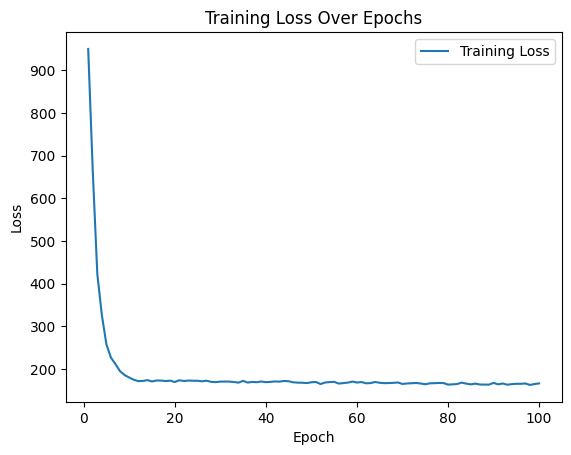

Surface F1 Score: 0.43815773764291965
Inside F1 Score: 0.7523133794918575
/kaggle/input/dataset-obj/2.obj
Epoch 00010: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 860.0527632863898
Epoch 2/100, Loss: 403.9205386513158
Epoch 00049: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 281.18093791760896
Epoch 00064: reducing learning rate of group 0 to 1.0000e-07.
Epoch 4/100, Loss: 226.19162469161185
Epoch 00084: reducing learning rate of group 0 to 1.0000e-08.
Epoch 5/100, Loss: 198.36474609375
Epoch 6/100, Loss: 200.2544668097245
Epoch 7/100, Loss: 203.90509916606703
Epoch 8/100, Loss: 200.0605822111431
Epoch 9/100, Loss: 197.70888960988898
Epoch 10/100, Loss: 199.17279454281456
Epoch 11/100, Loss: 197.00934480365953
Epoch 12/100, Loss: 196.3534746671978
Epoch 13/100, Loss: 195.23045670358758
Epoch 14/100, Loss: 190.1952193410773
Epoch 15/100, Loss: 195.58666349712172
Epoch 16/100, Loss: 196.21933384945518
Epoch 17/100, Loss: 191.89004677220396
E

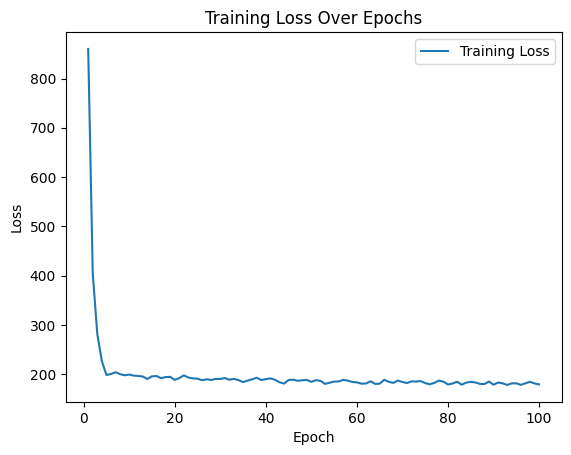

Surface F1 Score: 0.41742579209864333
Inside F1 Score: 0.9273760540448592
/kaggle/input/dataset-obj/12.obj
Epoch 1/100, Loss: 945.3790181477865
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 2/100, Loss: 897.6273193359375
Epoch 3/100, Loss: 609.2140401204427
Epoch 4/100, Loss: 437.3899434407552
Epoch 5/100, Loss: 361.4056854248047
Epoch 6/100, Loss: 309.5868835449219
Epoch 7/100, Loss: 280.66673278808594
Epoch 8/100, Loss: 253.1740290323893
Epoch 00054: reducing learning rate of group 0 to 1.0000e-06.
Epoch 9/100, Loss: 232.1557846069336
Epoch 10/100, Loss: 198.3371785481771
Epoch 11/100, Loss: 176.51717376708984
Epoch 12/100, Loss: 159.77387491861978
Epoch 13/100, Loss: 153.10810089111328
Epoch 14/100, Loss: 146.6404240926107
Epoch 00088: reducing learning rate of group 0 to 1.0000e-07.
Epoch 15/100, Loss: 146.2316157023112
Epoch 16/100, Loss: 141.0857925415039
Epoch 00097: reducing learning rate of group 0 to 1.0000e-08.
Epoch 17/100, Loss: 142.61971537272134
Epo

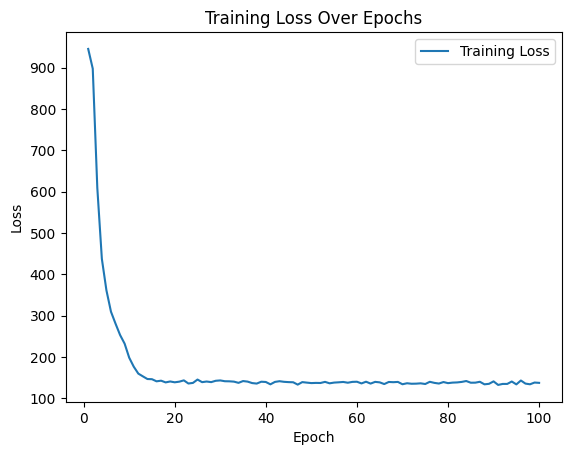

Surface F1 Score: 0.3867805372007208
Inside F1 Score: 0.7878141226276844
/kaggle/input/dataset-obj/35.obj
Epoch 1/100, Loss: 1001.9620090060764
Epoch 2/100, Loss: 996.2917548285591
Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3/100, Loss: 918.4954155815972
Epoch 4/100, Loss: 593.7391221788195
Epoch 5/100, Loss: 445.62623426649304
Epoch 6/100, Loss: 385.236809624566
Epoch 7/100, Loss: 340.8327467176649
Epoch 8/100, Loss: 313.73135715060766
Epoch 00074: reducing learning rate of group 0 to 1.0000e-06.
Epoch 9/100, Loss: 287.9259101019965
Epoch 00088: reducing learning rate of group 0 to 1.0000e-07.
Epoch 10/100, Loss: 243.55170016818576
Epoch 00098: reducing learning rate of group 0 to 1.0000e-08.
Epoch 11/100, Loss: 229.83203125
Epoch 12/100, Loss: 226.55108133951822
Epoch 13/100, Loss: 224.3159671359592
Epoch 14/100, Loss: 226.18241034613715
Epoch 15/100, Loss: 231.99734157986111
Epoch 16/100, Loss: 222.70990159776477
Epoch 17/100, Loss: 230.33880106608072
Epoch 

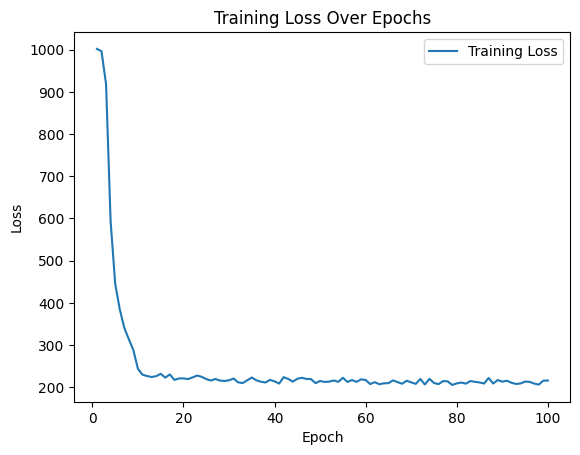

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.5639276688007478
Inside F1 Score: 0.9725218000974439
/kaggle/input/dataset-obj/25.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 932.7279793875558
Epoch 2/100, Loss: 518.4508187430246
Epoch 3/100, Loss: 332.5135977608817
Epoch 00050: reducing learning rate of group 0 to 1.0000e-06.
Epoch 4/100, Loss: 250.68678174700057
Epoch 5/100, Loss: 174.4821559361049
Epoch 00084: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6/100, Loss: 146.4308820452009
Epoch 7/100, Loss: 136.38344410487585
Epoch 00100: reducing learning rate of group 0 to 1.0000e-08.
Epoch 8/100, Loss: 133.57597187587194
Epoch 9/100, Loss: 132.02025386265345
Epoch 10/100, Loss: 130.6480004446847
Epoch 11/100, Loss: 132.56591524396623
Epoch 12/100, Loss: 134.5665544782366
Epoch 13/100, Loss: 135.4632682800293
Epoch 14/100, Loss: 133.68273707798548
Epoch 15/100, Loss: 134.99401473999023
Epoch 16/100, Loss: 134.32012067522322
Epoch 17/100, Loss: 133.42917033604212


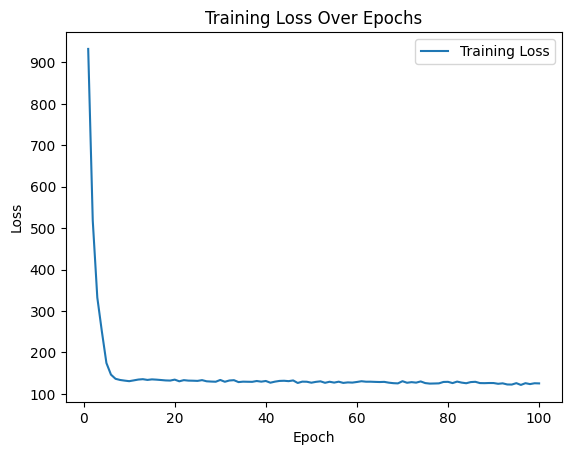

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.47742867079775886
Inside F1 Score: 0.9496509579323779
/kaggle/input/dataset-obj/47.obj
Epoch 1/100, Loss: 953.4085235595703
Epoch 2/100, Loss: 1010.8731689453125
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3/100, Loss: 952.9369506835938
Epoch 4/100, Loss: 709.9411163330078
Epoch 5/100, Loss: 555.5104217529297
Epoch 6/100, Loss: 479.4296188354492
Epoch 7/100, Loss: 437.34928131103516
Epoch 8/100, Loss: 399.0039596557617
Epoch 9/100, Loss: 360.0221939086914
Epoch 00038: reducing learning rate of group 0 to 1.0000e-06.
Epoch 10/100, Loss: 335.2592315673828
Epoch 11/100, Loss: 287.9840621948242
Epoch 12/100, Loss: 258.3904151916504
Epoch 13/100, Loss: 230.3959503173828
Epoch 14/100, Loss: 242.4316635131836
Epoch 00057: reducing learning rate of group 0 to 1.0000e-07.
Epoch 15/100, Loss: 237.13028717041016
Epoch 16/100, Loss: 233.33839797973633
Epoch 00067: reducing learning rate of group 0 to 1.0000e-08.
Epoch 17/100, Loss: 228.42162322998047
Epo

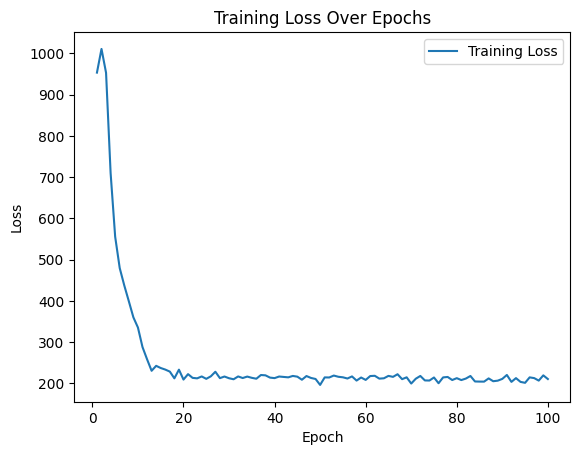

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.42777081779766346
Inside F1 Score: 0.5694293747566695
/kaggle/input/dataset-obj/44.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 860.3462890625
Epoch 2/100, Loss: 574.9968566894531
Epoch 3/100, Loss: 471.7171630859375
Epoch 4/100, Loss: 420.0162027994792
Epoch 00075: reducing learning rate of group 0 to 1.0000e-06.
Epoch 5/100, Loss: 374.14675089518227
Epoch 00081: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6/100, Loss: 349.7887390136719
Epoch 00105: reducing learning rate of group 0 to 1.0000e-08.
Epoch 7/100, Loss: 315.20660400390625
Epoch 8/100, Loss: 306.82887166341146
Epoch 9/100, Loss: 304.41541748046876
Epoch 10/100, Loss: 301.18544108072916
Epoch 11/100, Loss: 308.668369547526
Epoch 12/100, Loss: 302.5527872721354
Epoch 13/100, Loss: 299.0198120117187
Epoch 14/100, Loss: 297.3451639811198
Epoch 15/100, Loss: 299.67102864583336
Epoch 16/100, Loss: 299.49696044921876
Epoch 17/100, Loss: 296.4922322591146
Epoch

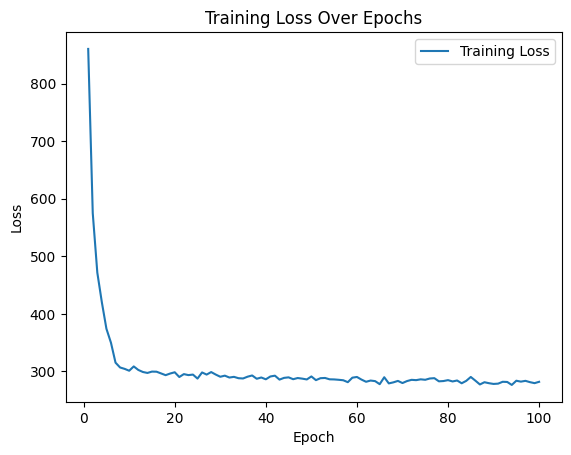

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.33348029984883737
Inside F1 Score: 0.020786387748974074
/kaggle/input/dataset-obj/49.obj
Epoch 1/100, Loss: 1025.0120646158855
Epoch 2/100, Loss: 1044.4022216796875
Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3/100, Loss: 1029.0018310546875
Epoch 4/100, Loss: 808.6306762695312
Epoch 5/100, Loss: 675.4336751302084
Epoch 6/100, Loss: 611.2849934895834
Epoch 7/100, Loss: 508.27614339192706
Epoch 8/100, Loss: 459.1685282389323
Epoch 9/100, Loss: 402.7814127604167
Epoch 10/100, Loss: 369.4120585123698
Epoch 11/100, Loss: 377.1988220214844
Epoch 12/100, Loss: 352.5314127604167
Epoch 13/100, Loss: 340.10439046223956
Epoch 14/100, Loss: 329.9691467285156
Epoch 15/100, Loss: 327.6764424641927
Epoch 16/100, Loss: 327.3634033203125
Epoch 00050: reducing learning rate of group 0 to 1.0000e-06.
Epoch 17/100, Loss: 319.39405314127606
Epoch 18/100, Loss: 267.1103820800781
Epoch 19/100, Loss: 231.48788452148438
Epoch 20/100, Loss: 208.54752604166666
Epoch 21

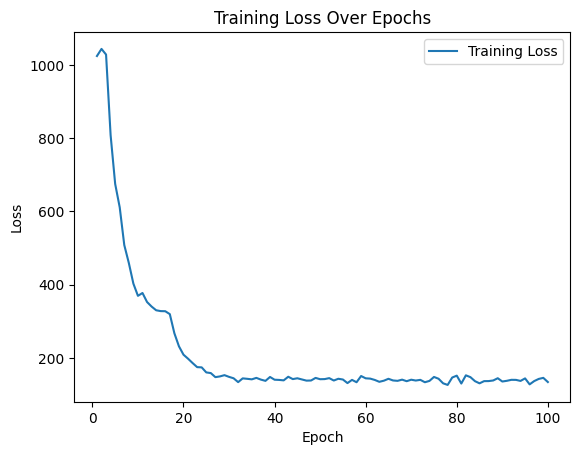

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.44629831010299964
Inside F1 Score: 0.7375511582932819
/kaggle/input/dataset-obj/36.obj
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 806.3473096575055
Epoch 2/100, Loss: 389.9950735909598
Epoch 00075: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 291.92840249197826
Epoch 00098: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00105: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 214.3855917794364
Epoch 5/100, Loss: 204.4160930088588
Epoch 6/100, Loss: 204.40947341918945
Epoch 7/100, Loss: 202.76277705601282
Epoch 8/100, Loss: 197.96227264404297
Epoch 9/100, Loss: 195.84807423182897
Epoch 10/100, Loss: 197.32612664358956
Epoch 11/100, Loss: 194.2447727748326
Epoch 12/100, Loss: 197.20886993408203
Epoch 13/100, Loss: 198.46323721749442
Epoch 14/100, Loss: 198.50464630126953
Epoch 15/100, Loss: 198.57430049351282
Epoch 16/100, Loss: 196.24993624005998
Epoch 17/100, Loss: 198.90338516235

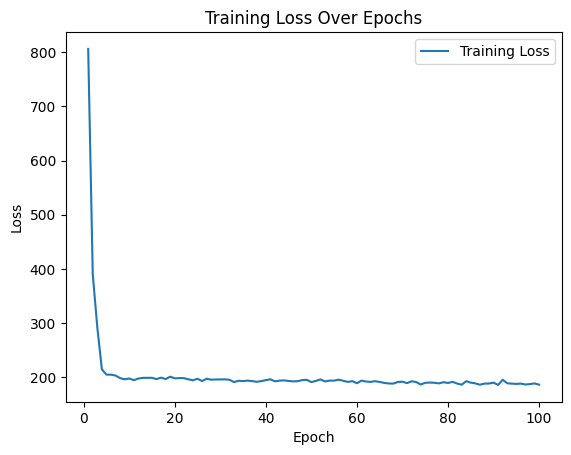

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.332033399295829
Inside F1 Score: 0.24368661971830985
/kaggle/input/dataset-obj/3.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 709.5447331181279
Epoch 2/100, Loss: 299.81729691116897
Epoch 00058: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00077: reducing learning rate of group 0 to 1.0000e-07.
Epoch 3/100, Loss: 184.96326418276186
Epoch 00084: reducing learning rate of group 0 to 1.0000e-08.
Epoch 4/100, Loss: 147.43890211317273
Epoch 5/100, Loss: 144.42203719527632
Epoch 6/100, Loss: 143.4490921585648
Epoch 7/100, Loss: 143.20048749005352
Epoch 8/100, Loss: 142.95084409360533
Epoch 9/100, Loss: 141.99128581859446
Epoch 10/100, Loss: 140.71860221580224
Epoch 11/100, Loss: 139.71176288746022
Epoch 12/100, Loss: 138.42973808006005
Epoch 13/100, Loss: 141.9576082582827
Epoch 14/100, Loss: 138.7434791282371
Epoch 15/100, Loss: 139.21879097267433
Epoch 16/100, Loss: 138.57050690827546
Epoch 17/100, Loss: 137.294700622558

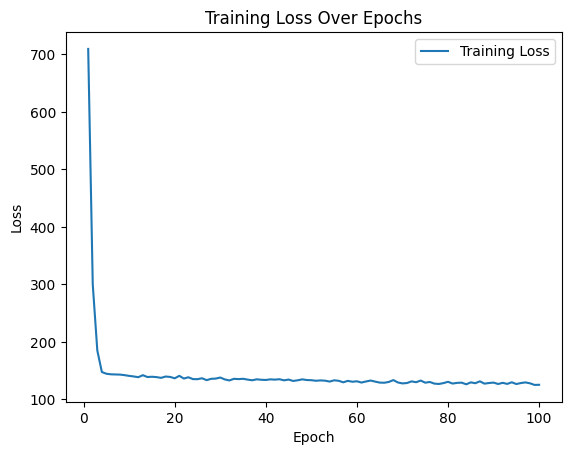

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))


Surface F1 Score: 0.4427038993710692
Inside F1 Score: 0.5276127754273556
/kaggle/input/dataset-obj/13.obj
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 992.6443481445312
Epoch 00013: reducing learning rate of group 0 to 1.0000e-06.
Epoch 2/100, Loss: 890.8740005493164
Epoch 3/100, Loss: 727.1194381713867
Epoch 4/100, Loss: 632.7772216796875
Epoch 5/100, Loss: 580.0747909545898
Epoch 6/100, Loss: 538.7023696899414
Epoch 7/100, Loss: 508.5974884033203
Epoch 8/100, Loss: 477.984130859375
Epoch 9/100, Loss: 463.70751953125
Epoch 00073: reducing learning rate of group 0 to 1.0000e-07.
Epoch 10/100, Loss: 455.9487762451172
Epoch 00084: reducing learning rate of group 0 to 1.0000e-08.
Epoch 11/100, Loss: 451.48582458496094
Epoch 12/100, Loss: 449.5086441040039
Epoch 13/100, Loss: 453.43902587890625
Epoch 14/100, Loss: 447.89606857299805
Epoch 15/100, Loss: 440.21083068847656
Epoch 16/100, Loss: 444.8392562866211
Epoch 17/100, Loss: 450.8141632080078
Epoch 18

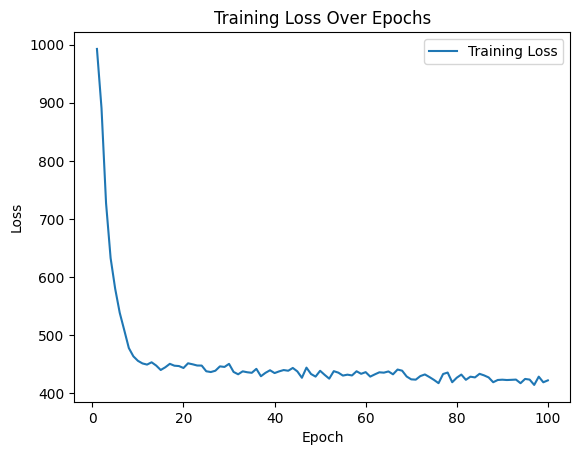

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.5727562514013862
Inside F1 Score: 0.8169415985164016
/kaggle/input/dataset-obj/8.obj
Epoch 1/100, Loss: 1109.3984549386162
Epoch 2/100, Loss: 1031.3105730329241
Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.
Epoch 3/100, Loss: 1068.3486153738838
Epoch 4/100, Loss: 859.9120483398438
Epoch 5/100, Loss: 619.674089704241
Epoch 6/100, Loss: 504.9258946010045
Epoch 7/100, Loss: 426.9499075753348
Epoch 8/100, Loss: 377.15689522879467
Epoch 9/100, Loss: 343.7190856933594
Epoch 10/100, Loss: 313.45159912109375
Epoch 11/100, Loss: 289.05113438197543
Epoch 00079: reducing learning rate of group 0 to 1.0000e-06.
Epoch 12/100, Loss: 272.3541041782924
Epoch 13/100, Loss: 260.44101170131137
Epoch 14/100, Loss: 229.4857439313616
Epoch 15/100, Loss: 223.31839425223214
Epoch 00112: reducing learning rate of group 0 to 1.0000e-07.
Epoch 16/100, Loss: 207.9607413155692
Epoch 00118: reducing learning rate of group 0 to 1.0000e-08.
Epoch 17/100, Loss: 212.5475594656808
Epo

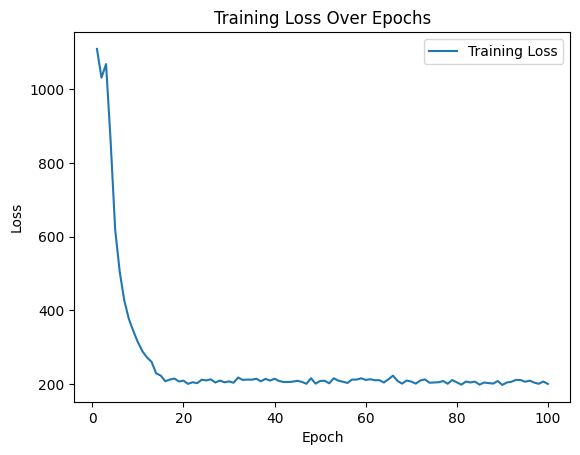

/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:622: RuntimeWarning: invalid value encountered in divide
  v = (d1[is_ab] / (d1[is_ab] - d3[is_ab])).reshape((-1, 1))
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:518: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:521: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 *
/opt/conda/lib/python3.10/site-packages/trimesh/triangles.py:523: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 *


Surface F1 Score: 0.1636372267730709
Inside F1 Score: 0.05717485919098822
/kaggle/input/dataset-obj/37.obj
Epoch 00013: reducing learning rate of group 0 to 1.0000e-05.
Epoch 1/100, Loss: 994.2382751464844
Epoch 2/100, Loss: 506.7332962036133
Epoch 00056: reducing learning rate of group 0 to 1.0000e-06.
Epoch 3/100, Loss: 300.1719940185547
Epoch 4/100, Loss: 187.68198471069337
Epoch 5/100, Loss: 152.9629753112793
Epoch 00109: reducing learning rate of group 0 to 1.0000e-07.
Epoch 6/100, Loss: 138.64562873840333
Epoch 00121: reducing learning rate of group 0 to 1.0000e-08.
Epoch 7/100, Loss: 136.13263282775878
Epoch 8/100, Loss: 137.2064437866211
Epoch 9/100, Loss: 136.13513107299804
Epoch 10/100, Loss: 137.95437660217286
Epoch 11/100, Loss: 138.16920166015626
Epoch 12/100, Loss: 137.91781005859374
Epoch 13/100, Loss: 135.3338607788086
Epoch 14/100, Loss: 135.24639129638672
Epoch 15/100, Loss: 137.4017333984375
Epoch 16/100, Loss: 136.33877716064453
Epoch 17/100, Loss: 134.0653598785400

KeyboardInterrupt: 

In [76]:
def main_loop():

    for dirname, _, filenames in os.walk('/kaggle/input/dataset-obj'):
        for filename in filenames:
            path_obj = os.path.join(dirname, filename)
            print(path_obj)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = Siren(in_features, hidden_features, hidden_layers, out_features).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=True, mode = "min")

            sdf_dataset = PointCloud(path_obj, on_surface_points= 256*4, off_surface_points = 256*8)
            dataloader = DataLoader(sdf_dataset, shuffle=True, batch_size=1, pin_memory=True, num_workers=0)

            trained_model = train_model_pipeline(model, optimizer, scheduler, sdf_dataset, dataloader,device, num_epochs)
            numbers = re.findall(r'\d+', str(path_obj))
            numbers = [int(num) for num in numbers]
            numbers = str(numbers[0])
            surf_f1, in_f1, batch_time = eval_model(path_obj, trained_model, device, numbers)

            surf_f1_lst.append(surf_f1)
            in_f1_lst.append(in_f1)
            batch_ret.append(batch_time)

main_loop()

In [ ]:
print(1)
